In [6]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/gdrive')
root_folder = "/content/gdrive/"

project_folder = root_folder + "/My Drive/Ext-val/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
conn_measures = ['PAC', 'SCR-(1,4)', 'SCI-(1,4)', 'PLV-(1,4)', 'PLI-(1,4)', 'CC-(1,4)', 'SCR-(4,8)', 'SCI-(4,8)', 'PLV-(4,8)', 'PLI-(4,8)', 'CC-(4,8)', 'SCR-(8,13)', 'SCI-(8,13)', 'PLV-(8,13)', 'PLI-(8,13)', 'CC-(8,13)', 'SCR-(13,30)', 'SCI-(13,30)', 'PLV-(13,30)', 'PLI-(13,30)', 'CC-(13,30)', 'SCR-(30,70)', 'SCI-(30,70)', 'PLV-(30,70)', 'PLI-(30,70)', 'CC-(30,70)', 'SCR-(70,150)', 'SCI-(70,150)', 'PLV-(70,150)', 'PLI-(70,150)', 'CC-(70,150)']

In [3]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
cm_subs = {
    "SCR": "Real spectral coherence",
    "SCI": "Imaginary spectral coherence",
    "PLV": "Phase-locking value",
    "PLI": "Phase lag index",
    "CC": "Cross-correlation",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\d+,\d+',s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC(30,70), SC_R(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print(output_str)


Cross-correlation(30,70), SC_R(70,150)


The game outcome data was saved in a separate Excel file for each subject and for thresholds of 2, 3 or 4 sigmas. To predict surgical outcomes, the data needs to be fused into a single dataframe.  

In [4]:
import os
import pandas as pd

# Path to the directory containing Excel files
xlsx_dir = project_folder + 'data_per_sigma/'

# Initialize empty dataframes for each type
df_0sigma = pd.DataFrame()
df_1sigma = pd.DataFrame()
df_2sigma = pd.DataFrame()
df_3sigma = pd.DataFrame()
df_4sigma = pd.DataFrame()

# Iterate through files in the directory
for filename in os.listdir(xlsx_dir):
    if filename.endswith('.xlsx'):
        # Extract type and subject ID from filename
        parts = filename.split('_')
        file_type = parts[-2]
        subject_id = parts[-1].split('.')[0]

        # Read Excel file into a dataframe
        file_path = os.path.join(xlsx_dir, filename)
        df = pd.read_excel(file_path)

        # Concatenate dataframe to the corresponding type dataframe
        if file_type == '0sigma':
            df_0sigma = pd.concat([df_1sigma, df], ignore_index=True)
        elif file_type == '1sigma':
            df_1sigma = pd.concat([df_1sigma, df], ignore_index=True)
        elif file_type == '2sigma':
            df_2sigma = pd.concat([df_2sigma, df], ignore_index=True)
        elif file_type == '3sigma':
            df_3sigma = pd.concat([df_3sigma, df], ignore_index=True)
        elif file_type == '4sigma':
            df_4sigma = pd.concat([df_4sigma, df], ignore_index=True)



NameError: name 'main_folder' is not defined

In [ ]:
# Save dataframes to Excel files
df_0sigma.to_excel(os.path.join(xlsx_dir,'surgical_outcome_data_0sigma.xlsx'), index=False)
df_1sigma.to_excel(os.path.join(xlsx_dir,'surgical_outcome_data_1sigma.xlsx'), index=False)
df_2sigma.to_excel(os.path.join(xlsx_dir,'surgical_outcome_data_2sigma.xlsx'), index=False)
df_3sigma.to_excel(os.path.join(xlsx_dir,'surgical_outcome_data_3sigma.xlsx'), index=False)
df_4sigma.to_excel(os.path.join(xlsx_dir,'surgical_outcome_data_4sigma.xlsx'), index=False)


The code below checks if there are any zero Mean_overlap_ratio in the data. If yes, it fetches the value from the same index in the previous sigma file (sigma-1) and continues with the analysis. If a zero is found in row `zero_row_index` in the current sigma file, it replaces the corresponding value with the one from the previous sigma file.


In [7]:
xlsx_dir = project_folder + 'data_per_sigma/'

load_data_ori = None

sigma = 4
while sigma > 0:
    load_data_ori = pd.read_excel(xlsx_dir + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

    # Check if "Mean_overlap_ratio" contains any zeros
    zero_row_indices = load_data_ori.index[load_data_ori["Mean_overlap_ratio"] == 0].tolist()

    if zero_row_indices:
        print(f"Zeros found in rows {zero_row_indices} for sigma={sigma}")
        if sigma == 0:
            print("Skipping iteration for sigma=1 with zeros")
            break

        sigma -= 1
        prev_load_data_ori = pd.read_excel(xlsx_dir + f"surgical_outcome_data_{sigma}sigma.xlsx", engine='openpyxl')

        for zero_row_index in zero_row_indices:
            zero_value = prev_load_data_ori.loc[zero_row_index, "Mean_overlap_ratio"]
            load_data_ori.loc[zero_row_index, "Mean_overlap_ratio"] = zero_value
    else:
        break  # No zeros found, exit the loop

Zeros found in rows [63, 64, 65, 74, 78, 88, 93, 94, 96, 97, 100, 101, 106, 108, 109, 111, 112, 116, 118, 121, 314, 315, 316, 330, 343, 346, 354, 356, 379, 399, 400, 403, 405, 406, 407, 408, 410, 411, 414, 416, 419, 421, 422, 423, 424, 430, 439, 443, 447, 450, 451, 453, 455, 456, 457, 477, 658, 713] for sigma=4
Zeros found in rows [63, 64, 74, 88, 93, 94, 96, 97, 100, 106, 108, 109, 112, 116, 118, 121, 316, 343, 356, 379, 399, 400, 405, 406, 407, 410, 414, 416, 419, 422, 423, 424, 430, 439, 450, 451, 453, 455, 456, 457, 477, 713] for sigma=3
Zeros found in rows [63, 64, 88, 94, 96, 97, 100, 106, 108, 109, 112, 116, 118, 121, 343, 400, 410, 414, 422, 424, 430, 450, 453, 455, 457] for sigma=2
Zeros found in rows [32, 38, 46, 47, 50, 54, 56, 59, 267, 276, 290, 300] for sigma=1


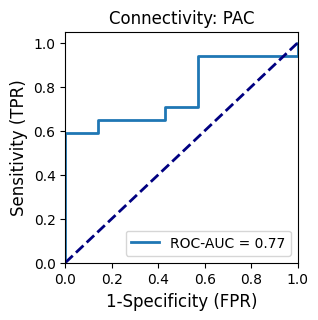

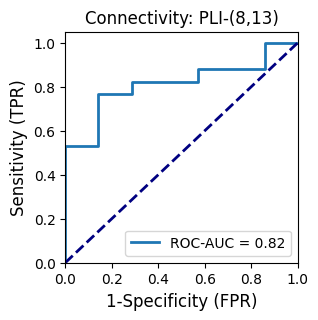

In [11]:
load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

# Loop through each connectivity measure
for cm in conn_measures:
    # Group the data by method and get the group for the current connectivity measure
    data = load_data.groupby("CM").get_group(cm)
    scores, actual_labels = list(data.Mean_overlap_ratio), list(data.Outcome)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(actual_labels, scores)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    # Compute Youden's index
    youden_index = tpr - fpr
    best_threshold_index = np.argmax(youden_index)

    # Sensitivity and specificity at the best threshold
    sens = tpr[best_threshold_index]
    spec = 1 - fpr[best_threshold_index]

    # Append the results to the list
    results.append({
        'CM': cm,
        'AUC': roc_auc,
        'Sensitivity': sens,
        'Specificity': spec
    })

    # Plot the ROC curve if AUC > 0.7
    if roc_auc > 0.7: # Remove of modify this logic to print all/specific ROC curves
        cm_str = substitute_bands(cm)

        plt.figure(figsize=(3, 3))
        plt.plot(fpr, tpr, lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "1cm_rocauc_results_ext.xlsx", index=False)

In [17]:
# Function to compute AUC, sensitivity, and specificity for a given combination of connectivity measures
def compute_metrics_for_combination(cm_combination, load_data, n_subjects=24):

    combined_scores = []
    actual_labels = None

    for cm in cm_combination:

        data = load_data[load_data['CM'] == cm]
        if data['Mean_overlap_ratio'].values.shape[0] == n_subjects:
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
        else: break

    if len(combined_scores) == len(cm_combination):

      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      roc_auc = auc(fpr, tpr)

      # Compute Youden's index
      youden_index = tpr - fpr
      best_threshold_index = np.argmax(youden_index)

      # Sensitivity and specificity at the best threshold
      sens = tpr[best_threshold_index]
      spec = 1 - fpr[best_threshold_index]

      return roc_auc, sens, spec

    else: return None, None, None

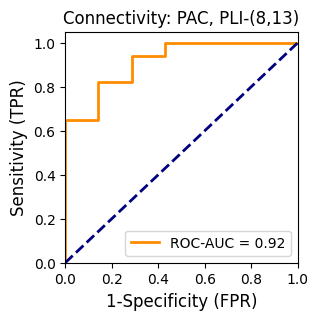

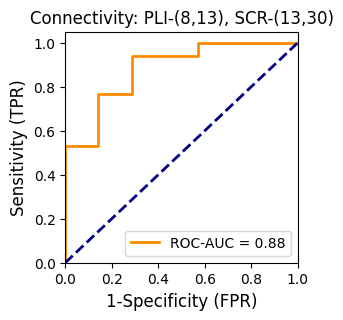

In [18]:
# Generate combinations of 2 connectivity measures

results = []

load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

for cm_combination in itertools.combinations(conn_measures, 2):

    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      combination_str = ', '.join(cm_combination)
      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve

      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

      if roc_auc > 0.85:

        cm_str = substitute_bands(combination_str)

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "2cm_rocauc_results_ext.xlsx", index=False)

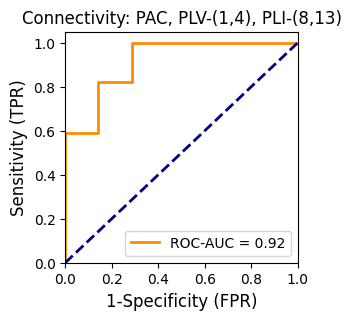

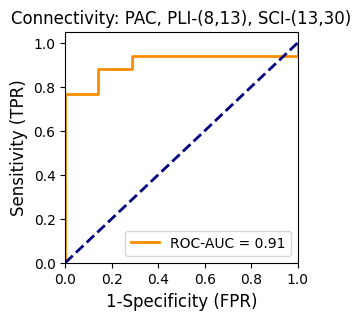

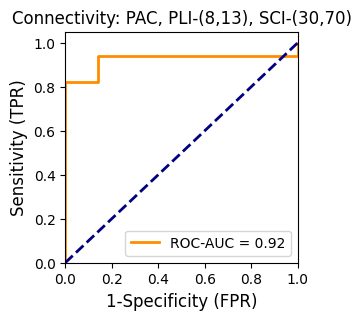

In [19]:
# Generate combinations of 3 connectivity measures

load_data = load_data_ori[load_data_ori['Strategy'] == "mm"]

results = []

for cm_combination in itertools.combinations(conn_measures, 3):
    combination_str = ', '.join(cm_combination)
    roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

    if roc_auc != None:
      # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

      # Append the results to the list
      results.append({
          'CM': combination_str,
          'AUC': roc_auc,
          'Sensitivity': sens,
          'Specificity': spec
      })

      # Plot the ROC curve
      combined_scores = []
      actual_labels = None
      for cm in cm_combination:
          data = load_data[load_data['CM'] == cm]
          if actual_labels is None:
              actual_labels = data['Outcome'].values
          combined_scores.append(data['Mean_overlap_ratio'].values)
      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

      if roc_auc > 0.9:

        cm_str = substitute_bands(combination_str)

        plt.figure(figsize=(3,3))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Specificity (FPR)', size=12)
        plt.ylabel('Sensitivity (TPR)', size=12)
        plt.title(f'Connectivity: {cm_str}')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(project_folder + "3cm_rocauc_results_ext.xlsx", index=False)